In [ ]:
import openai
import langchain_core
from langchain.tools import Tool
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory.buffer import ConversationBufferMemory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import numpy as np
import os
import re
import random as rand
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#from langchain_openai.chat_models import ChatOpenAI
#from langchain.chains import LLMChain
#from langchain.prompts import PromptTemplate
#from operator import itemgetter
#from typing import (List, Optional)
#from langchain.memory.chat_memory import BaseChatMemory
#from langchain_core.documents import Document
#from langchain_core.messages import BaseMessage, AIMessage
#from langchain_core.pydantic_v1 import BaseModel, Field
#from langchain_core.runnables import (
    #RunnableLambda,
    #ConfigurableFieldSpec,
    #RunnablePassthrough,
#)
#from langchain_core.callbacks import StreamingStdOutCallbackHandler
#from langchain_core.utils.function_calling import convert_to_openai_tool
#from transformers import (AutoModelForCausalLM, AutoTokenizer, pipeline)
#from langchain.llms import HuggingFacePipeline
#import uuid
#import torch
#from langchain_openai import OpenAI
#from math import exp

In [ ]:
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"
root_path = "root_path"

In [20]:
class OpenAIChatWrapper:
    def __init__(self, model, **kwargs):
        self.model = model
        self.default_params = kwargs

    def _convert_messages(self, messages):
        '''Converts LangChain message objects to OpenAI API compatible format'''
        converted = []
        for msg in messages:
            if isinstance(msg, langchain_core.messages.human.HumanMessage):
                converted.append({"role": "user", "content": msg.content})
            elif isinstance(msg, langchain_core.messages.ai.AIMessage):
                converted.append({"role": "assistant", "content": msg.content})
            elif isinstance(msg, langchain_core.messages.system.SystemMessage):
                converted.append({"role": "system", "content": msg.content})
            else:
                raise TypeError(f"Unsupported message type: {type(msg)}")
        return converted

    def __call__(self, prompt):
        '''Checks if the input is a LangChain-style message list and convert if necessary'''
        if isinstance(prompt, langchain_core.prompt_values.ChatPromptValue):
            prompt = self._convert_messages(prompt.to_messages())
        else:
            raise TypeError(f"Unsupported message type")

        # direct OpenAI API call
        client = openai.OpenAI()
        completion = client.chat.completions.create(
            model=self.model,
            messages=prompt,
            **self.default_params
        )
        if "logprobs" in self.default_params.keys():
            top_logprobs = completion.choices[0].logprobs.content[0].top_logprobs
            tokens = [_.token for _ in top_logprobs]
            logprobs = [str(prob) for prob in np.round(np.exp([_.logprob for _ in top_logprobs]), 4)]
            to_write = " | ".join([f"{token}: {prob}" for token, prob in zip(tokens, logprobs)])
            f = open("logprobs.txt", "a")
            f.write(to_write + '\n')
            f.close()
           
        return completion.choices[0].message.content

class ChatRoom:
    def __init__(self, llm, memories={}):
        self.llm = llm
        prompt = ChatPromptTemplate.from_messages([
                    MessagesPlaceholder(variable_name="chat_memory"),
                     ("human", "{question}"),
                  ])
        chain = prompt | llm
        self.chain = chain

        self.memories = memories
        def get_by_session_id(session_id: str) -> BaseChatMessageHistory:
            if session_id not in self.memories.keys():
                memory = ConversationBufferMemory(memory_key="chat_memory", return_messages=True)
                self.memories[session_id] = memory
            return self.memories[session_id].chat_memory

        runnable = RunnableWithMessageHistory(
                        chain,
                        get_by_session_id,
                        input_messages_key="question",
                        history_messages_key="chat_memory")
        self.runnable = runnable

    def start_chat(self, session_ids, auto_input=None, **kwargs):
        '''
        supports multiple human-LLM chat sessions (there's one human and one LLM in each session,
        and the LLM is of the same model)
        session_ids: list of session ids
        auto_input: function that automatically crafts prompts that takes the
            - prompt number (i-th input)
            - self.memories
            - session_ids
        as a positional argumants, and can take other keyword argumants whose values will be fixed throughout the method.
        '''
        i = 1
        if auto_input is None:
            human_inputs = [input(ID+':') for ID in session_ids]
        else:
            human_inputs = auto_input(i, self.memories, session_ids, **kwargs)
            print(human_inputs)
        if human_inputs == ["end chat"]*len(human_inputs):
            return None
        while True:
            responses = [self.runnable.invoke(
                            {"question": input_},
                              config={"configurable": {"session_id": ID}}
            ) for input_, ID in zip(human_inputs, session_ids)]

            response_contents = [r.content if type(r) != str else r for r in responses]
            print(response_contents)
            i += 1
            if auto_input is None:
                human_inputs = [input(ID+":") for ID in session_ids]
            else:
                #print("i = "", i)
                human_inputs = auto_input(i, self.memories, session_ids, **kwargs)
                print(human_inputs)
            if human_inputs == ["end chat"]*len(human_inputs):
                break
            while 'end chat' in human_inputs:
                session_ids.pop(human_inputs.index("end chat"))
                human_inputs.pop(human_inputs.index("end chat"))

In [ ]:
# LLM as Player 1
kuhn_poker_instructions_1 = '''You will be playing 90 repeated rounds of a Poker game as player 1 against an opponent (player 2). Here are the game rules:
Each player antes 1 chip. Each player is dealt a unique card from a deck consisting of only a Jack (J), a Queen (Q), and a King (K). The third card not dealt is left unseen.
Player 1 can check or bet 1 chip.
If player 1 checks, player 2 can check or bet 1 chip.
  > If player 2 checks, a showdown occurs.
  > If player 2 bets, player 1 can fold or call.
      > If player 1 folds, player 2 takes the entire pot.
      > If player 1 calls, a showdown occurs.
If player 1 bets, player 2 can fold or call.
  > If player 2 folds, player one takes the entire pot.
  > If player 2 calls, a showdown occurs.

At the beginning of each round (except for the first), you will be provided with a complete history of past game results in shorthand notation, and the card you are dealt in the current round will be given at the end:

- Each pair of parentheses denotes a round.
    - The card and the action on the left are yours (player 1).
    - The card and the action on the right are player 2's.
    - The action after "/" denotes your (player 1's) action after player 2 has taken an action, if the round comes to this.
    - In this example: in round 1, you (player 1) had a K and bet, while player 2 had a Q and subsequently called. In round 2, you (payer 1) had a J and checked, player 2 had a K and subsequently bet, which led to your (player 1's) turn again, where you folded. So on and so forth.
- The card after "|" denotes the card you are dealt in the current round.

In addition, as the rounds progress, you will be provided with a game results summary. The summary will include the average payoffs for both players and the action frequencies for each card. The summary will be updated every 15 rounds.
Please use the history and summary provided to analyze game trends and opponent behavior. Adapt your strategy and choose your actions accordingly. In each round, please provide your choice of action as player 1. Note that if you checked and your opponent bet, you will be asked again to call or fold.
Round 1 starts now. Your card is {}. Please provide your choice of action in the following format without any explanation: Bet/Check.'''

# LLM as Player 2
kuhn_poker_instructions_2 = '''You will be playing 90 repeated rounds of a Poker game as player 2 against an opponent (player 1). Here are the game rules:
Each player antes 1 chip. Each player is dealt a unique card from a deck consisting of only a Jack (J), a Queen (Q), and a King (K). The third card not dealt is left unseen.
Player 1 can check or bet 1 chip.
If player 1 checks, player 2 can check or bet 1 chip.
  > If player 2 checks, a showdown occurs.
  > If player 2 bets, player 1 can fold or call.
      > If player 1 folds, player 2 takes the entire pot.
      > If player 1 calls, a showdown occurs.
If player 1 bets, player 2 can fold or call.
  > If player 2 folds, player one takes the entire pot.
  > If player 2 calls, a showdown occurs.

At the beginning of each round (except for the first), you will be provided with a complete history of past game results in shorthand notation, and the card you are dealt in the current round will be given at the end:

- Each pair of parentheses denotes a round.
    - The card and the action on the left are player 1's.
    - The card and the action on the right are player 2's (yours).
    - The action after "/" denotes player 1's action after player 2 (you) has taken an action, if the round comes to this.
    - In this example: in round 1, player 1 had a K and bet, while player 2 (you) had a Q and subsequently called. In round 2, payer 1 had a J and checked, player 2 (you) had a K and subsequently bet, which led to player 1's turn again, where they folded. So on and so forth.
- The card after "|" denotes the card you are dealt in the current round.

In addition, as the rounds progress, you will be provided with a game results summary. The summary will include the average payoffs for both players and the action frequencies for each card. The summary will be updated every 15 rounds.
Please use the history and summary provided to analyze game trends and opponent behavior. Adapt your strategy and choose your actions accordingly. In each round, please provide your choice of action as player 2.
Round 1 starts now. Your card is {}, and player 1 has chosen to {}. Please provide your choice of action as player 2 in the following format without any explanation: Bet/Check/Call/Fold.'''


def generate_bot_action(bot_strategy, bot_player_num, card_tuple, llm_action, alpha=1/6):
    '''card_tuple: (player1_card, player2_card)'''
    epsilon = 1/15
    if bot_player_num == 1:
        if llm_action is None:
            if bot_strategy == "nash":
                if card_tuple[0] == "K":
                    bot_action = rand.choices(["Bet", "Check"], weights=[epsilon+3*alpha, 1-3*alpha-epsilon], k=1)[0]
                elif card_tuple[0] == "Q":
                    bot_action = "Check"
                else:
                    bot_action = rand.choices(["Bet", "Check"], weights=[epsilon+alpha, 1-alpha-epsilon], k=1)[0]
            elif bot_strategy == "random":
                bot_action = rand.choice(["Bet", "Check"]) 
        else: # llm_action = "Bet"
            if bot_strategy == "nash":
                if card_tuple[0] == "K":
                    bot_action = "Call"
                    #bot_action = rand.choices(["Call", "Fold"], weights=[epsilon, 1-epsilon], k=1)[0]
                elif card_tuple[0] == "Q": 
                    bot_action = rand.choices(["Call", "Fold"], weights=[epsilon+alpha+1/3, 2/3-alpha-epsilon], k=1)[0]
                else: # bot_card = 'J'
                    bot_action = "Fold"
                    #bot_action = rand.choices(["Fold", "Call"], weights=[epsilon, 1-epsilon], k=1)[0]
            elif bot_strategy == "random":
                bot_action = rand.choice(["Call", "Fold"])

    else: # bot_player_num == 2
        if llm_action in ("Call", "Fold"):
            return None

        if bot_strategy == "nash":
            if card_tuple[1] == "K":
                if llm_action == "Check":
                    bot_action = "Bet"
                else: bot_action = "Call"
            elif card_tuple[1] == "Q":
                if llm_action == "Check":
                    bot_action = rand.choices(["Check", "Bet"], weights=[1-epsilon, epsilon], k=1)[0]
                else: bot_action = rand.choices(["Call", "Fold"], weights=[epsilon+1/3, 2/3-epsilon], k=1)[0]

            else: # bot_card = "J"
                if llm_action == "Check": 
                    bot_action = rand.choices(["Bet", "Check"], weights=[epsilon+1/3, 2/3-epsilon], k=1)[0]              
                else:
                    bot_action = "Fold"
                    

        elif bot_strategy == "copy":
            bot_action = "Call" if llm_action == "Bet" else "Check"

        elif bot_strategy == "random":
            if llm_action == "Bet":
                bot_action = rand.choice(["Call", "Fold"])
            else:
                bot_action = rand.choice(["Bet", "Check"]) 
                
    return bot_action



def get_total_summary(history, past_summary, N, batch_size=30): # N current round number
    current_history_summary = get_current_history_summary(history)
    
    template = '''
ROUNDS 1 - {}

Player 1 (Average Payoff: {})
K: Bet * {} ({}%) / Check * {} ({}%)
Q: Bet * {} ({}%) / Check * {} ({}%) 
J: Bet * {} ({}%) / Check * {} ({}%)
=======================
K: Call * {} ({}%) / Fold * {} ({}%)
Q: Call * {} ({}%) / Fold * {} ({}%) 
J: Call * {} ({}%) / Fold * {} ({}%) 

Player 2 (Average Payoff: {})
K: Bet * {} ({}%) / Check * {} ({}%) / Call * {} ({}%) / Fold * {} ({}%)
Q: Bet * {} ({}%) / Check * {} ({}%) / Call * {} ({}%) / Fold * {} ({}%)
J: Bet * {} ({}%) / Check * {} ({}%) / Call * {} ({}%) / Fold * {} ({}%)
'''  
    
    if past_summary is not None:       
        avg_payoffs = re.findall(r'Average Payoff:\s*(-?\d+(?:\.\d+)?)', past_summary)
        avg_payoffs = [float(p) for p in avg_payoffs]
        print("avg_payoffs: ", avg_payoffs)

        num_of_past_rounds = N - 1 - batch_size
        print("num_of_past_rounds: ", num_of_past_rounds)
        print("N_1", N-1)
        print("current_history_summary.p1_avg_payoff: ", current_history_summary.p1_avg_payoff)
        p1_avg_payoff = (avg_payoffs[0] * num_of_past_rounds + current_history_summary.p1_avg_payoff*batch_size) / (N-1)
        p2_avg_payoff = (avg_payoffs[1] * num_of_past_rounds + current_history_summary.p2_avg_payoff*batch_size) / (N-1)

        pattern = r'\*\s*(\d+(?:\.\d+)?)'
        past_stats = re.findall(pattern, past_summary)
        past_stats = np.array([int(num) for num in past_stats])   
        
        bet_p1 = past_stats[[0,2,4]] + current_history_summary.bet_p1
        check_p1 = past_stats[[1,3,5]] + current_history_summary.check_p1
        bet_rates_p1, check_rates_p1 = np.round(bet_p1 / (bet_p1 + check_p1) * 100, 2), np.round(check_p1 / (bet_p1 + check_p1) * 100, 2)
        
        call_p1 = past_stats[[6,8,10]] + current_history_summary.call_p1
        fold_p1 = past_stats[[7,9,11]] + current_history_summary.fold_p1
        call_rates_p1, fold_rates_p1 = np.round(call_p1 / (call_p1 + fold_p1) * 100, 2), np.round(fold_p1 / (call_p1 + fold_p1) * 100, 2)
          
        bet_p2 = past_stats[[12,16,20]] + current_history_summary.bet_p2
        check_p2 = past_stats[[13,17,21]] + current_history_summary.check_p2
        call_p2 = past_stats[[14,18,22]] + current_history_summary.call_p2
        fold_p2 = past_stats[[15,19,23]] + current_history_summary.fold_p2
        denom = bet_p2 + check_p2 + call_p2 + fold_p2
        bet_rates_p2, check_rates_p2, call_rates_p2, fold_rates_p2 = np.round(bet_p2 / denom * 100, 2), np.round(check_p2 / denom * 100, 2), np.round(call_p2 / denom * 100, 2), np.round(fold_p2 / denom * 100, 2)

        block1 = np.array([bet_p1, bet_rates_p1, check_p1, check_rates_p1], dtype=object).T.flatten()
        block2 = np.array([call_p1, call_rates_p1, fold_p1, fold_rates_p1], dtype=object).T.flatten()
        block3 = np.array([bet_p2, bet_rates_p2, check_p2, check_rates_p2, call_p2, call_rates_p2, fold_p2, fold_rates_p2], dtype=object).T.flatten()
           
        total_summary = template.format(N-1, *[x for x in [round(p1_avg_payoff, 4),
                                                      *block1,
                                                      *block2,
                                                      round(p2_avg_payoff, 4),
                                                      *block3]])

    else:
        denom1 = current_history_summary.bet_p1 + current_history_summary.check_p1
        denom2 = current_history_summary.call_p1 + current_history_summary.fold_p1
        denom3 = current_history_summary.bet_p2 + current_history_summary.check_p2 + current_history_summary.call_p2 + current_history_summary.fold_p2
        block1 = np.array([current_history_summary.bet_p1,
                           np.round(current_history_summary.bet_p1 / denom1 * 100, 2),
                           current_history_summary.check_p1,
                           np.round(current_history_summary.check_p1 / denom1 * 100, 2),
                           ], dtype=object).T.flatten()   
        block2 = np.array([current_history_summary.call_p1,
                           np.round(current_history_summary.call_p1 / denom2 * 100, 2),
                           current_history_summary.fold_p1,
                           np.round(current_history_summary.fold_p1 / denom2 * 100, 2), 
                           ], dtype=object).T.flatten()
        block3 = np.array([current_history_summary.bet_p2,
                           np.round(current_history_summary.bet_p2 / denom3 * 100, 2), 
                           current_history_summary.check_p2,
                           np.round(current_history_summary.check_p2 / denom3 * 100, 2), 
                           current_history_summary.call_p2,
                           np.round(current_history_summary.call_p2 / denom3 * 100, 2), 
                           current_history_summary.fold_p2,
                           np.round(current_history_summary.fold_p2 / denom3 * 100, 2)], dtype=object).T.flatten()

        total_summary = template.format(N-1, *[x for x in [round(current_history_summary.p1_avg_payoff, 4),
                                                      *block1,
                                                      *block2,
                                                      round(current_history_summary.p2_avg_payoff, 4),
                                                      *block3]])  
    
    return total_summary

def get_current_history_summary(history):
    p1_avg_payoff, p2_avg_payoff = calculate_avg_payoff(history, 1), calculate_avg_payoff(history, 2)

    history = [h.strip().split(";") for h in history.split('>')]
    idx_dict = {(1, "K"): (1, "K"), (1, "Q"): (1, "Q"), (1, "J"): (1, "J"),
                (2, "K"): (4, "K"), (2, "Q"): (4, "Q"), (2, "J"): (4, "J")}
    
    bet_p1, check_p1, bet_p2, check_p2, call_p1, fold_p1, fold_p2, call_p2 = [], [], [], [], [], [], [], []

    for k in list(idx_dict.keys())[:3]:  
        history_filt = list(filter(lambda x: x[0][idx_dict[k][0]]==idx_dict[k][1], history))
    
        num_of_bets = sum(h[1][1:4]=="Bet" for h in history_filt)
        bet_p1.append(num_of_bets)
        check_p1.append(len(history_filt) - num_of_bets)               

        num_of_second_stage_games = sum([1 for h in history_filt if "/" in h[1]])
        num_of_calls = sum("/" in h[1] and h[1].split("/")[1][1:5]=="Call" for h in history_filt)
        call_p1.append(num_of_calls)
        fold_p1.append(num_of_second_stage_games - num_of_calls)       

    for k in list(idx_dict.keys())[3:]:  
        history_filt = list(filter(lambda x: x[0][idx_dict[k][0]]==idx_dict[k][1], history))
        num_of_bets = sum(h[1].split(",")[1][1:4]=="Bet" for h in history_filt)
        bet_p2.append(num_of_bets)
        num_of_checks = sum(h[1].split(",")[1][1:6]=="Check" for h in history_filt)
        check_p2.append(num_of_checks)
        num_of_calls = sum(h[1].split(",")[1][1:5]=="Call" for h in history_filt)
        call_p2.append(num_of_calls)   
        fold_p2.append(len(history_filt) - num_of_bets - num_of_checks - num_of_calls)
    
    CurrentHistorySummary = namedtuple("CurrentHistorySummary", ["p1_avg_payoff", "p2_avg_payoff",
                                                                 "bet_p1", "check_p1",
                                                                 "bet_p2", "check_p2", "call_p2", "fold_p2",
                                                                 "call_p1", "fold_p1"])
    current_history_summary = CurrentHistorySummary(p1_avg_payoff, p2_avg_payoff,
                                                    np.array(bet_p1), np.array(check_p1), 
                                                    np.array(bet_p2), np.array(check_p2), np.array(call_p2), np.array(fold_p2),
                                                    np.array(call_p1), np.array(fold_p1))
    return current_history_summary


def calculate_avg_payoff(history, player_num):
    history = [h.strip().split(";") for h in history.split('>')]
    payoff_dict = {' Bet, Fold)': -1, ' Bet, Call)': 2, ' Check, Check)': 1,
                   ' Check, Bet / Fold)': -1, ' Check, Bet / Call)': 2,
                  }

    payoffs = []

    if player_num == 1:
        for card_config, actions_played in history:
            sign = 1 if card_config in ('(K, Q' , '(K, J' , '(Q, J') else -1
            if "/ Fold" in actions_played:
                payoff = -1 
            elif "Bet, Fold" in actions_played:
                payoff = 1 
            else:
                payoff = payoff_dict[actions_played] * sign 
            payoffs.append(payoff)

    else:
        for card_config, actions_played in history:
            sign = 1 if card_config in ('(Q, K' , '(J, K' , '(J, Q') else -1
            if "/ Fold" in actions_played:
                payoff = 1
            elif "Bet, Fold" in actions_played:
                payoff = -1
            else:
                payoff = payoff_dict[actions_played] * sign
            payoffs.append(payoff)  
    return sum(payoffs) / len(payoffs) 
    

def kuhn_auto_input(num, memories, session_ids, llm_player_num=1, bot_strategy='nash', card_sequence=[], alpha=1/6):
    '''card_sequence: list of tuples of card faces: [(K, J), (Q, K), (K, Q), ...], left is Player 1, right is Player 2'''
    
    def write_to_file(text):
        f = open("repeated_rounds.txt", "a")
        f.write(text + '\n')
        f.close()
        
    if num == 1:
        if llm_player_num == 1:
            return [kuhn_poker_instructions_1.format(card_sequence[0][0])]
        else:
            bot_action = generate_bot_action(bot_strategy, 1, card_sequence[0], None)
            return [kuhn_poker_instructions_2.format(card_sequence[0][1], bot_action.lower())]

    else:
        all_llm_responses = [memories[session_ids[0]].chat_memory.messages[2*_+1].content for _ in range(num-1)]
        all_llm_actions = [re.search(r'Bet|Check|Call|Fold', _).group() for _ in all_llm_responses]
        all_llm_actions_filt = list(filter(lambda x: x in ("Bet","Check"), all_llm_actions)) if llm_player_num ==1 else all_llm_actions.copy()
        llm_action = all_llm_actions[-1]
        N = len(all_llm_actions_filt)
        if N > len(card_sequence):
            return ["end chat"]

        player1_card, player2_card = card_sequence[N-1]

        lst = [1, 2]
        lst.remove(llm_player_num)
        bot_player_num = lst[0]
        #bot_action = generate_bot_action(bot_strategy, bot_player_num, (player1_card, player2_card), llm_action)

        round_instruct = ' | Your card is {} \n Based on past game histories and opponent behavior, estimate your action probabilities and choose accordingly. Please provide your choice of action as player 1 in the following format without any explanation: Bet/Check.'

        if llm_player_num == 1:
            bot_action = generate_bot_action(bot_strategy, bot_player_num, (player1_card, player2_card), llm_action)
            if bot_action != None:
                if (llm_action, bot_action) != ('Check', 'Bet'):
                    if num == 2:
                        prompt = f'({player1_card}, {player2_card}; {llm_action}, {bot_action})' + round_instruct.format(card_sequence[N][0])
                    else:
                        history = memories[session_ids[0]].chat_memory.messages[-2].content.split('|')[0]
                        write_to_file(history) 
                        
                        if N % 15 == 1:   
                            past_summary = None if N==16 else history.split('>', 1)[0].strip() 
                            current_history = history if N==16 else history.split('>', 1)[1].strip() 
                            history = get_total_summary(current_history, past_summary, N, batch_size=15) 
                 
                        try:
                            prompt = history + f'> ({player1_card}, {player2_card}; {llm_action}, {bot_action})' + round_instruct.format(card_sequence[N][0])
                        except IndexError:
                            print('\n', history + f'> ({player1_card}, {player2_card}; {llm_action}, {bot_action})\n')
                            prompt = "end chat"
                else:
                    prompt = f"You checked and your opponent bet, so it's your turn to call or fold (Your card is {player1_card}). Please provide your choice of action in the following format without any explanation: Call/Fold."
            else: # bot_action == None
                if num == 3:
                    prompt = f'({player1_card}, {player2_card}; Check, Bet / {llm_action})' + round_instruct.format(card_sequence[N][0])
                else:
                    history = memories[session_ids[0]].chat_memory.messages[-4].content.split('|')[0]
                    print("!!!!! history: ", history)
                    write_to_file(history) 
                    
                    if N % 15 == 1:   
                        past_summary = None if N==16 else history.split('>', 1)[0].strip() 
                        current_history = history if N==16 else history.split('>', 1)[1].strip() 
                        history = get_total_summary(current_history, past_summary, N, batch_size=15)
                    
                    try:
                        prompt = history + f'> ({player1_card}, {player2_card}; Check, Bet / {llm_action})' + round_instruct.format(card_sequence[N][0])
                    except IndexError:
                        print('\n', history + f'> ({player1_card}, {player2_card}; Check, Bet / {llm_action})\n')
                        prompt = "end chat"


        else: # llm_player_num == 2:
            player1_card, player2_card = card_sequence[N-1]
            previous_prompt = memories[session_ids[0]].chat_memory.messages[-2].content 
            #print("previous_prompt: ", previous_prompt)
            previous_bot_action = re.search(r'player 1 has chosen to (\w+)\.', previous_prompt).group(1)
            #print("previous_bot: ", previous_bot_action)

            if (previous_bot_action, llm_action) != ('check', 'Bet'):
                bot_action = generate_bot_action(bot_strategy, bot_player_num, (card_sequence[N][0], card_sequence[N][1]), None, alpha=alpha)
                if num == 2:
                    previous_bot_action = "Check" if previous_bot_action == "check" else "Bet"
                    prompt = f'({player1_card}, {player2_card}; {previous_bot_action}, {llm_action})' + f' | Your card is {card_sequence[N][1]}, and player 1 has chosen to {bot_action.lower()}. Based on past game histories and opponent behavior, estimate your action probabilites and choose accordingly.\nPlease provide your choice of action as player 2 in the following format without any explanation: Bet/Check/Call/Fold.'
                else:
                    history = memories[session_ids[0]].chat_memory.messages[-2].content.split('|')[0]
                    write_to_file(history) 
                    if N % 15 == 1:   
                        past_summary = None if N==16 else history.split('>', 1)[0].strip() 
                        current_history = history if N==16 else history.split('>', 1)[1].strip() 
                        history = get_total_summary(current_history, past_summary, N, batch_size=15) 
                    previous_bot_action = "Check" if previous_bot_action == "check" else "Bet"
                    try:
                        prompt = history + f'> ({player1_card}, {player2_card}; {previous_bot_action}, {llm_action})' + f' | Your card is {card_sequence[N][1]}, and player 1 has chosen to {bot_action.lower()}. Based on past game histories and opponent behavior, estimate your action probabilities and choose accordingly. \nPlease provide your choice of action as player 2 in the following format without any explanation: Bet/Check/Call/Fold.'
                    except IndexError:
                        print('\n', history + f'> ({player1_card}, {player2_card}; {previous_bot_action}, {llm_action})\n')
                        prompt = "end chat"
            else:
                _bot_action_ = generate_bot_action(bot_strategy, bot_player_num, (player1_card, player2_card), "Bet", alpha=alpha)
                bot_action = generate_bot_action(bot_strategy, bot_player_num, (card_sequence[N][0], card_sequence[N][1]), None, alpha=alpha)
                if num == 2:
                    prompt = f'({player1_card}, {player2_card}; Check, Bet / {_bot_action_})' + f' | Your card is {card_sequence[N][1]}, and player 1 has chosen to {bot_action.lower()}. Based on past game histories and opponent behavior, estimate your action probabilities and choose accordingly. Please provide your choice of action as player 2 in the following format without any explanation: Bet/Check/Call/Fold.'
                else:
                    history = memories[session_ids[0]].chat_memory.messages[-2].content.split('|')[0]
                    write_to_file(history) 
                    if N % 15 == 1:   
                        past_summary = None if N==16 else history.split('>', 1)[0].strip() 
                        current_history = history if N==16 else history.split('>', 1)[1].strip() 
                        history = get_total_summary(current_history, past_summary, N, batch_size=15) 
                    try:
                        prompt = history + f'> ({player1_card}, {player2_card}; Check, Bet / {_bot_action_})' + f' | Your card is {card_sequence[N][1]}, and player 1 has chosen to {bot_action.lower()}. Based on past game histories and opponent behavior, estimate your action probabilities and choose accordingly. \nPlease provide your choice of action as player 2 in the following format without any explanation: Bet/Check/Call/Fold.'
                    except IndexError:
                        print('\n', history + f'> ({player1_card}, {player2_card}; Check, Bet / {_bot_action_})\n')
                        prompt = "end chat"
        return [prompt]

In [ ]:
os.chdir("chdir1")

In [25]:
# test if models understand history
test_prompt = '''You will be playing 90 repeated rounds of a Poker game as player 1 against an opponent (player 2). Here are the game rules:
Each player antes 1 chip. Each player is dealt a unique card from a deck consisting of only a Jack (J), a Queen (Q), and a King (K). The third card not dealt is left unseen.
Player 1 can check or bet 1 chip.
If player 1 checks, player 2 can check or bet 1 chip.
  > If player 2 checks, a showdown occurs.
  > If player 2 bets, player 1 can fold or call.
      > If player 1 folds, player 2 takes the entire pot.
      > If player 1 calls, a showdown occurs.
If player 1 bets, player 2 can fold or call.
  > If player 2 folds, player one takes the entire pot.
  > If player 2 calls, a showdown occurs.

At the beginning of each round (except for the first), you will be provided with a complete history of past game results in shorthand notation, and the card you are dealt in the current round will be given at the end:

- Each pair of parentheses denotes a round.
    - The card and the action on the left are yours (player 1).
    - The card and the action on the right are player 2's.
    - The action after "/" denotes your (player 1's) action after player 2 has taken an action, if the round comes to this.
- The card after "|" denotes the card you are dealt in the current round.

Please clearly explain the following game history:
(J, Q; Bet, Fold) > (K, J; Check, Check) > (Q, K; Check, Bet / Call)
'''

def get_llm_response(model, prompt, temp=0.2):
    client =openai.OpenAI()
    if model[0] != "o":
        response = client.chat.completions.create(
                messages=[
                    {
                    "role": "user",
                    "content": prompt
                    }
                    ],
                    model=model,
                    temperature=temp,
                    logprobs=True
                )
    else:
        response = client.chat.completions.create(
                messages=[
                    {
                    "role": "user",
                    "content": prompt
                    }
                    ],
                    model=model,
                )    
    print(response.choices[0].message.content)
    return response

models_to_test = [("gpt-4-turbo", 0.2), ("gpt-4-turbo", 0.8), ("gpt-4o", 0.2), ("gpt-4o", 0.8), ("o3-mini", None)]
for model, temp in models_to_test:
    print(f"\n***Testing model {model} at temperature={temp}***\n")
    get_llm_response(model, test_prompt, temp=temp)


***Testing model gpt-4-turbo at temperature=0.2***

The game history provided describes the outcomes of three rounds of the Poker game you played against your opponent. Here's a breakdown of each round:

1. **First Round: (J, Q; Bet, Fold)**
   - **Your Card:** Jack (J)
   - **Opponent's Card:** Queen (Q)
   - **Your Action:** You bet 1 chip.
   - **Opponent's Action:** Your opponent folds.
   - **Outcome:** Since your opponent folds, you win the pot without a showdown. You collect the chips from the pot, which includes your ante, your opponent's ante, and your bet.

2. **Second Round: (K, J; Check, Check)**
   - **Your Card:** King (K)
   - **Opponent's Card:** Jack (J)
   - **Your Action:** You check.
   - **Opponent's Action:** Your opponent also checks.
   - **Outcome:** Both players check, leading to a showdown. Since a King is higher than a Jack, you win the pot, which consists of the antes from both players.

3. **Third Round: (Q, K; Check, Bet / Call)**
   - **Your Card:** Que

In [12]:
openai_tool_turbo = Tool(
    name="Custom OpenAI Chat",
    func=OpenAIChatWrapper(model="gpt-4-turbo",temperature=0.2, logprobs=True, top_logprobs=4),
    description="Calls OpenAI's GPT-4-Turbo with custom settings.")
chatroom_turbo = ChatRoom(openai_tool_turbo.func)

openai_tool_4o = Tool(
    name="Custom OpenAI Chat",
    func=OpenAIChatWrapper(model="gpt-4o",temperature=0.4, logprobs=True, top_logprobs=4),
    description="Calls OpenAI's GPT-4o with custom settings.")
chatroom_4o = ChatRoom(openai_tool_4o.func)

openai_tool_o3 = Tool(
    name="Custom OpenAI Chat",
    func=OpenAIChatWrapper(model="o3-mini"),
    description="Calls OpenAI's o3-mini with custom settings.")
chatroom_o3 = ChatRoom(openai_tool_o3.func)


card_seq = [("Q","J"),("K","J"),("J","K"),("K","Q"),("Q","K"),("J","Q")]*15
rand.shuffle(card_seq)
card_seq = card_seq + [("J", "Q"), ("K", "Q")]

In [ ]:
chatroom_turbo.start_chat([str(0)], auto_input=kuhn_auto_input, llm_player_num=1,
                            bot_strategy="nash", card_sequence=card_seq)
chatroom_turbo.memories.clear()

In [ ]:
chatroom_4o.start_chat([str(0)], auto_input=kuhn_auto_input, llm_player_num=2,
                            bot_strategy="nash", card_sequence=card_seq)
chatroom_4o.memories.clear()

In [ ]:
chatroom_o3.start_chat([str(0)], auto_input=kuhn_auto_input, llm_player_num=1,
                            bot_strategy="nash", card_sequence=card_seq)
chatroom_o3.memories.clear()

In [ ]:
os.chdir("/log-files")

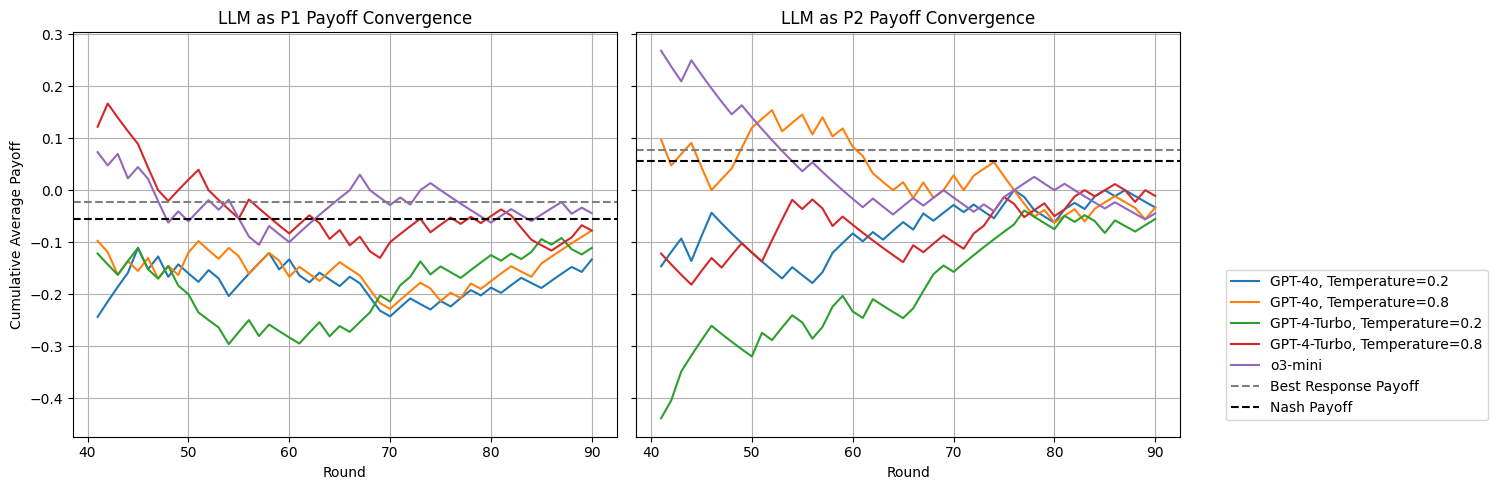

In [30]:
def get_history_from_file(filename):
    f = open(filename, "r")
    lines = list(filter(lambda x: "gpt" not in x and "o3" not in x, f.readlines()))
    f.close()
    history = " > ".join(lines)
    return history

def get_payoff_per_round(player_num, history=None, filename=None):
    if history is None:
        history = get_history_from_file(filename)

  
    history = [h.strip().split(";") for h in history.split('>')]
    payoff_dict = {' Bet, Fold)': -1, ' Bet, Call)': 2, ' Check, Check)': 1,
                   ' Check, Bet / Fold)': -1, ' Check, Bet / Call)': 2,
                  }
    payoffs = []
    if player_num == 1:
        for card_config, actions_played in history:
            sign = 1 if card_config in ('(K, Q' , '(K, J' , '(Q, J') else -1
            if "/ Fold" in actions_played:
                payoff = -1 
            elif "Bet, Fold" in actions_played:
                payoff = 1 
            else:
                payoff = payoff_dict[actions_played] * sign 
            payoffs.append(payoff)

    else:
        for card_config, actions_played in history:
            sign = 1 if card_config in ('(Q, K' , '(J, K' , '(J, Q') else -1
            if "/ Fold" in actions_played:
                payoff = 1
            elif "Bet, Fold" in actions_played:
                payoff = -1
            else:
                payoff = payoff_dict[actions_played] * sign
            payoffs.append(payoff) 
    return payoffs


def plot_cumulative_avg_subplots(models_payoffs_p1, models_payoffs_p2, player_num1=1, player_num2=2,
                                 best_response_p1=-1/45, best_response_p2=7/90, save_path=None):
    nash_payoff_p1 = -1/18
    nash_payoff_p2 = 1/18
    
    cumulative_avgs_p1 = np.empty(len(models_payoffs_p1), dtype=object)
    cumulative_avgs_p2 = np.empty(len(models_payoffs_p2), dtype=object)
    
    for i, payoffs in enumerate(models_payoffs_p1.values()):
        cumulative_avgs_p1[i] = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)
    for i, payoffs in enumerate(models_payoffs_p2.values()):
        cumulative_avgs_p2[i] = np.cumsum(payoffs) / np.arange(1, len(payoffs) + 1)
    
    x = list(range(1, 91))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    # plot for player 1
    for cumulative_avg, model in zip(cumulative_avgs_p1, models_payoffs_p1.keys()):
        ax1.plot(x[-50:], cumulative_avg[-50:], label=model)
    ax1.axhline(y=best_response_p1, linestyle='--', color='gray', label='Best Response Payoff')
    ax1.axhline(y=nash_payoff_p1, linestyle='--', color='black', label='Nash Payoff')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Cumulative Average Payoff')
    ax1.set_title(f'LLM as P{player_num1} Payoff Convergence')
    ax1.grid(True)
    
    # plot for player 2
    for cumulative_avg, model in zip(cumulative_avgs_p2, models_payoffs_p2.keys()):
        ax2.plot(x[-50:], cumulative_avg[-50:], label=model)
    ax2.axhline(y=best_response_p2, linestyle='--', color='gray')
    ax2.axhline(y=nash_payoff_p2, linestyle='--', color='black')
    ax2.set_xlabel('Round')
    ax2.set_title(f'LLM as P{player_num2} Payoff Convergence')
    ax2.grid(True)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.25, 0.3))
    plt.tight_layout()  
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  
    plt.show()

files_p1 = ["4o-t0.2-p1-game-records.txt", "4o-t0.8-p1-game-records.txt",
            "turbo-t0.2-p1-game-records.txt", "turbo-t0.8-p1-game-records.txt",
            "o3-mini-p1-game-records.txt"]
files_p2 = ["4o-t0.2-p2-game-records.txt", "4o-t0.8-p2-game-records.txt",
            "turbo-t0.2-p2-game-records.txt", "turbo-t0.8-p2-game-records.txt",
            "o3-mini-p2-game-records.txt"]
payoffs_list_p1 = [get_payoff_per_round(1, history=None, filename=f) for f in files_p1]
payoffs_list_p2 = [get_payoff_per_round(2, history=None, filename=f) for f in files_p2]
keys = ["GPT-4o, Temperature=0.2", "GPT-4o, Temperature=0.8",
        "GPT-4-Turbo, Temperature=0.2", "GPT-4-Turbo, Temperature=0.8",
        "o3-mini"]
models_payoffs_p1 = dict(zip(keys, payoffs_list_p1))
models_payoffs_p2 = dict(zip(keys, payoffs_list_p2))
plot_cumulative_avg_subplots(models_payoffs_p1, models_payoffs_p2, save_path=root_path+"/plots/cumulative_avg_payoffs.png")

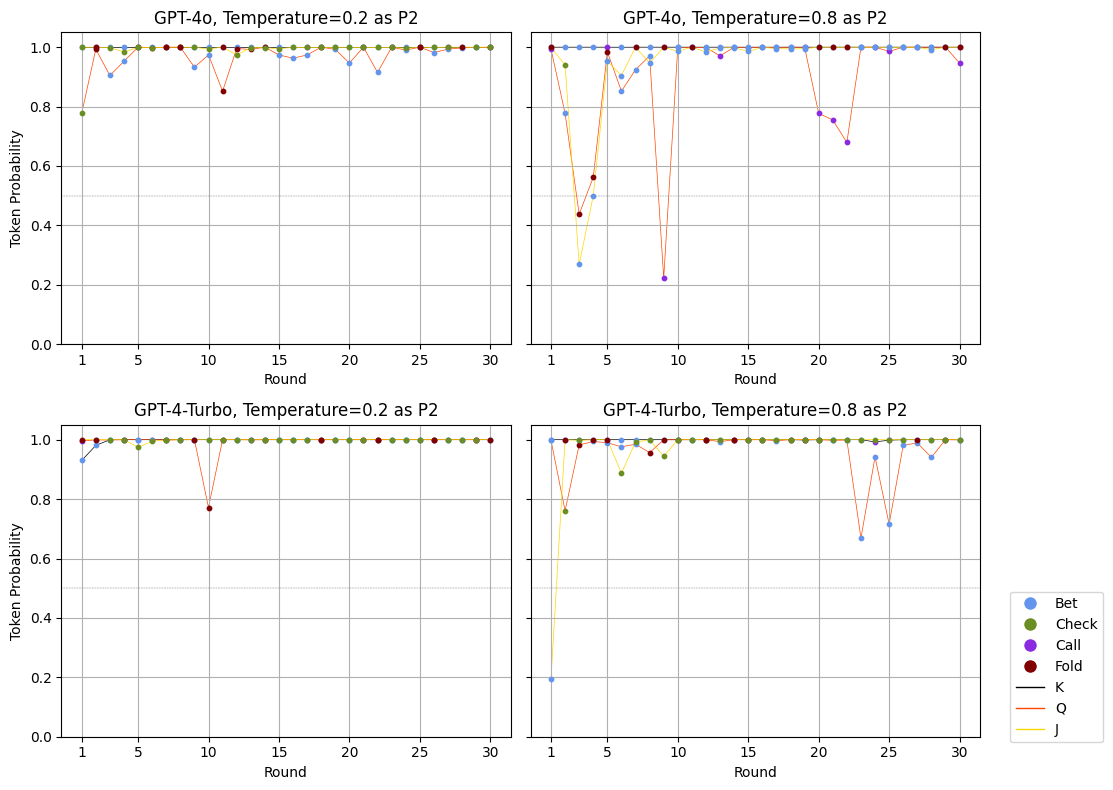

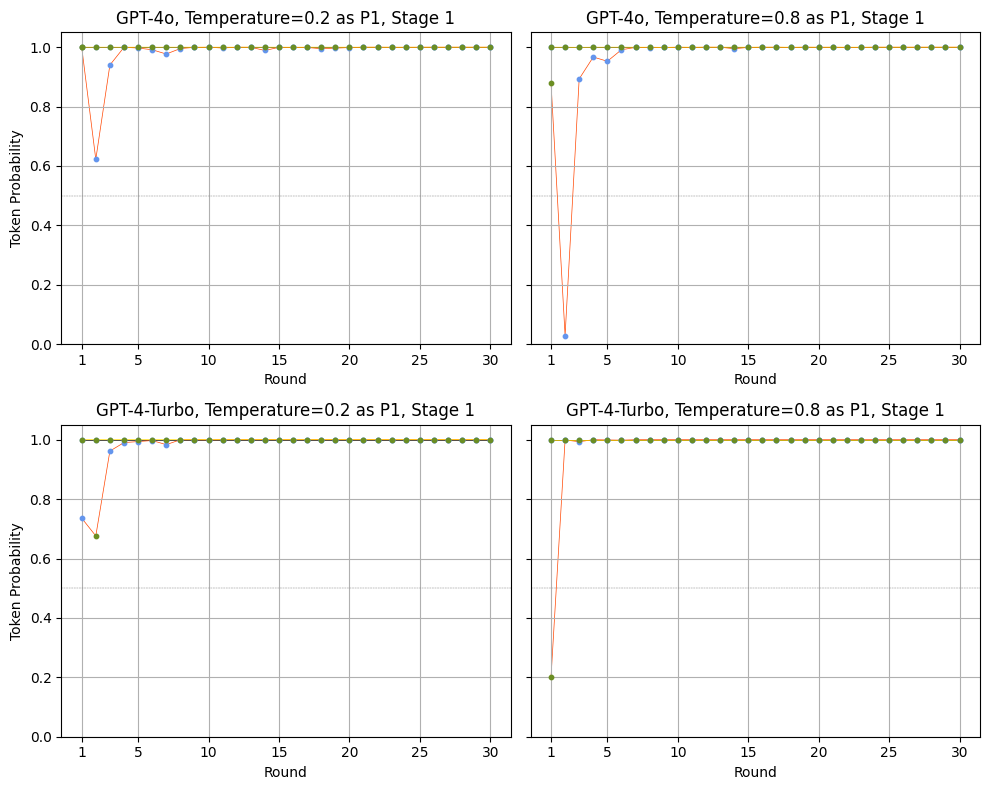

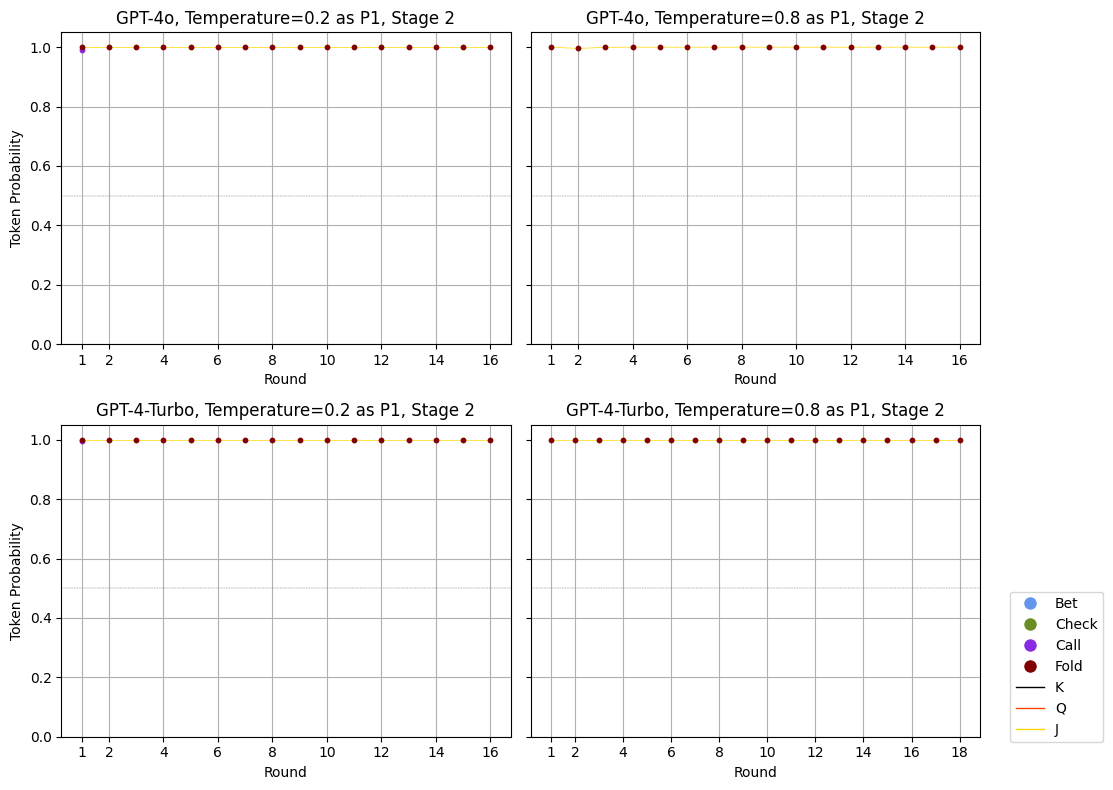

In [31]:
def get_tokenprobs_from_file(filename, stage1=True):
    f = open(filename, "r")
    lines = list(filter(lambda x: "gpt" not in x and "o3" not in x, f.readlines()))
    f.close()

    if stage1:
        lines = [(l.split("|")[0].strip().split(": "), l.split("|")[1].strip().split(": ")) for l in lines]
        lines = [(l[0], ["", "0"]) if l[1][0] == l[0][0] else (l[0], l[1]) for l in lines]
        tokenprobs = [{l1[0]: float(l1[1]), l2[0]: float(l2[1])} for l1, l2 in lines]
    else:
        lines = list(filter(lambda x: "; " in x, lines))
        lines = [l.split("; ")[1].strip() for l in lines]
        lines = [(l.split("|")[0].strip().split(": "), l.split("|")[1].strip().split(": ")) for l in lines]
        lines = [(l[0], ["", "0"]) if l[1][0] == l[0][0] else (l[0], l[1]) for l in lines]
        tokenprobs = [{l1[0]: float(l1[1]), l2[0]: float(l2[1])} for l1, l2 in lines]

    return tokenprobs

def plot_tokenprobs_subplots(llm_player_num, histories, tokenprobs_list, plot_names, plot_stage2=False, save_path=None):
    idx1 = 0 if llm_player_num == 1 else 1
    idx2 = 1 if llm_player_num == 1 else 4
    action_colors = {'Bet': 'cornflowerblue', 'Check': 'olivedrab', 'Call': 'blueviolet', 'Fold': 'maroon'}
    line_colors = {"K": "black", "Q": "orangered", "J": "gold"}

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    axes = axes.flatten()

    for ax, history, tokenprobs, plot_name in zip(axes, histories, tokenprobs_list, plot_names):
        for card in line_colors.keys():
            if not plot_stage2:
                filt = [(h, t) for h, t in zip(history, tokenprobs) if h[idx2] == card]
                history_filt, tokenprobs_filt = zip(*filt) if filt else ([], [])
                
                if history_filt:
                    actions = [h.split("; ")[1].split(", ")[idx1].split(" / ")[0].split(")")[0] for h in history_filt]
                    tokenprobs_filt = [tokenprob[action] for action, tokenprob in zip(actions, tokenprobs_filt)]
                    x = list(range(1, 31))
                    ax.plot(x[:len(tokenprobs_filt)], tokenprobs_filt, color=line_colors[card], linestyle="-", 
                            linewidth=0.5, zorder=1, label=f"{card}")
                    colors = [action_colors[a] for a in actions]
                    for xi, yi, ci in zip(x[:len(tokenprobs_filt)], tokenprobs_filt, colors):
                        ax.scatter(xi, yi, color=ci, s=10, zorder=2)
            
            elif plot_stage2 and llm_player_num == 1:
                history_stage2 = list(filter(lambda x: "/" in x, history))
                filt_stage2 = [(h, t) for h, t in zip(history_stage2, tokenprobs) if h[idx2] == card]
                history_filt_stage2, tokenprobs_filt_stage2 = zip(*filt_stage2) if filt_stage2 else ([], [])
                
                if history_filt_stage2:
                    actions_stage2 = [h.split("; ")[1].split(" / ")[1].split(")")[0] for h in history_filt_stage2]
                    tokenprobs_filt_stage2 = [tokenprob[action] for action, tokenprob in zip(actions_stage2, tokenprobs_filt_stage2)]
                    x_ = list(range(1, len(tokenprobs_filt_stage2) + 1))
                    ax.plot(x_, tokenprobs_filt_stage2, color=line_colors[card], linestyle="-", 
                            linewidth=0.5, zorder=1, label=f"{card}")
                    colors = [action_colors[a] for a in actions_stage2]
                    for xj, yj, cj in zip(x_, tokenprobs_filt_stage2, colors):
                        ax.scatter(xj, yj, color=cj, s=10, zorder=2)

        ax.set_xlabel("Round")
        if "0.8" not in plot_name:
            ax.set_ylabel('Token Probability')
        ax.set_ylim(0, 1.05)
        ax.axhline(y=0.5, linestyle='--', linewidth=0.35, color='gray')
        
        if not plot_stage2:
            ax.set_xticks([1, 5, 10, 15, 20, 25, 30])
        else:
            x_len = len(tokenprobs_filt_stage2) if 'tokenprobs_filt_stage2' in locals() else 30
            ax.set_xticks([1] + list(range(2, x_len + 1, 2)))
        
        stage = ", Stage 2" if plot_stage2 and llm_player_num == 1 else ", Stage 1" if llm_player_num == 1 else ""   
        ax.set_title(f'{plot_name} as P{llm_player_num}{stage}')
        ax.grid(True)
        to_remove = ax.get_ygridlines()[5]
        to_remove.set_visible(False)

    if llm_player_num == 2 or (llm_player_num == 1 and plot_stage2):
        action_legend = [Line2D([0], [0], marker='o', color='w', label=action, markerfacecolor=col, markersize=10)
                         for action, col in action_colors.items()]
        line_legend = [Line2D([0], [0], color=col, lw=1, label=f"{card}")
                       for card, col in line_colors.items()]
        fig.legend(handles=action_legend + line_legend, loc='center right', bbox_to_anchor=(1.115, 0.16))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  
    plt.show()
    plt.close()

game_records_files_p2 = ["4o-t0.2-p2-game-records.txt", "4o-t0.8-p2-game-records.txt",
                         "turbo-t0.2-p2-game-records.txt", "turbo-t0.8-p2-game-records.txt"]
tokenprobs_files_p2 = ["4o-t0.2-p2-logprobs.txt", "4o-t0.8-p2-logprobs.txt",
                       "turbo-t0.2-p2-logprobs.txt", "turbo-t0.8-p2-logprobs.txt"]
game_records_files_p1 = ["4o-t0.2-p1-game-records.txt", "4o-t0.8-p1-game-records.txt",
                         "turbo-t0.2-p1-game-records.txt", "turbo-t0.8-p1-game-records.txt"]
tokenprobs_files_p1 = ["4o-t0.2-p1-logprobs.txt", "4o-t0.8-p1-logprobs.txt",
                       "turbo-t0.2-p1-logprobs.txt", "turbo-t0.8-p1-logprobs.txt"]
plot_names = ["GPT-4o, Temperature=0.2", "GPT-4o, Temperature=0.8",
              "GPT-4-Turbo, Temperature=0.2", "GPT-4-Turbo, Temperature=0.8"]

# player 2
histories_p2 = []
tokenprobs_list_p2 = []
for tokenprobs_file, history_file in zip(tokenprobs_files_p2, game_records_files_p2):
    tokenprobs = get_tokenprobs_from_file(tokenprobs_file, stage1=True)
    history = get_history_from_file(history_file)
    history = [h.strip() for h in history.split('>')]
    histories_p2.append(history)
    tokenprobs_list_p2.append(tokenprobs)
plot_tokenprobs_subplots(2, histories_p2, tokenprobs_list_p2, plot_names,
                         save_path=root_path+"/plots/player2_tokenprobs.png")

# player 1, stage 1
histories_p1 = []
tokenprobs_list_p1 = []
for tokenprobs_file, history_file in zip(tokenprobs_files_p1, game_records_files_p1):
    tokenprobs = get_tokenprobs_from_file(tokenprobs_file, stage1=True)
    history = get_history_from_file(history_file)
    history = [h.strip() for h in history.split('>')]
    histories_p1.append(history)
    tokenprobs_list_p1.append(tokenprobs)
plot_tokenprobs_subplots(1, histories_p1, tokenprobs_list_p1, plot_names, plot_stage2=False,
                         save_path=root_path+"/plots/player1_stage1_tokenprobs.png")

# player 1, stage 2
histories_p1_stage2 = []
tokenprobs_list_p1_stage2 = []
for tokenprobs_file, history_file in zip(tokenprobs_files_p1, game_records_files_p1):
    tokenprobs = get_tokenprobs_from_file(tokenprobs_file, stage1=False)
    history = get_history_from_file(history_file)
    history = [h.strip() for h in history.split('>')]
    histories_p1_stage2.append(history)
    tokenprobs_list_p1_stage2.append(tokenprobs)
plot_tokenprobs_subplots(1, histories_p1_stage2, tokenprobs_list_p1_stage2, plot_names, plot_stage2=True, 
                         save_path=root_path+"/plots/player1_stage2_tokenprobs.png")